# DynamoDB RCU Provisioning Optimization - ML Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("dynamodb_rcu_raw_dataset.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()


,Timestamp,ConsumedRCU,ProvisionedRCU,TargetUtilization(TG),ActualUtilization,ProvisioningStatus
0,2025-07-01 00:00:00,2074,3456,0.6,0.600,Balanced
1,2025-07-01 01:00:00,2186,3643,0.6,0.600,Balanced
2,2025-07-01 02:00:00,2497,3567,0.7,0.700,Balanced
3,2025-07-01 03:00:00,2794,4656,0.6,0.600,Balanced
4,2025-07-01 04:00:00,2657,4550,0.8,0.584,Over-Provisioned


## Feature Engineering

In [2]:
df["Hour"] = df["Timestamp"].dt.hour
df["DayOfWeek"] = df["Timestamp"].dt.dayofweek
df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)
df["GrowthRate"] = df["ConsumedRCU"].pct_change().fillna(0)
df["RollingMeanRCU"] = df["ConsumedRCU"].rolling(window=3, min_periods=1).mean()

# Encode the provisioning status
df["StatusLabel"] = df["ProvisioningStatus"].map({
    "Over-Provisioned": 0,
    "Balanced": 1,
    "Under-Provisioned": 2
})

df.head()


,Timestamp,ConsumedRCU,ProvisionedRCU,TargetUtilization(TG),ActualUtilization,ProvisioningStatus,Hour,DayOfWeek,IsWeekend,GrowthRate,RollingMeanRCU,StatusLabel
0,2025-07-01 00:00:00,2074,3456,0.6,0.600,Balanced,0,1,0,0.000000,2074.000000,1
1,2025-07-01 01:00:00,2186,3643,0.6,0.600,Balanced,1,1,0,0.054002,2130.000000,1
2,2025-07-01 02:00:00,2497,3567,0.7,0.700,Balanced,2,1,0,0.142269,2252.333333,1
3,2025-07-01 03:00:00,2794,4656,0.6,0.600,Balanced,3,1,0,0.118943,2492.333333,1
4,2025-07-01 04:00:00,2657,4550,0.8,0.584,Over-Provisioned,4,1,0,-0.049034,2649.333333,0


## Train/Test Split

In [3]:
features = ["ConsumedRCU", "ProvisionedRCU", "TargetUtilization(TG)", "Hour", "DayOfWeek", "IsWeekend", "GrowthRate", "RollingMeanRCU"]
X = df[features]
y = df["StatusLabel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Random Forest Classifier

In [4]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.84        52
           1       0.87      0.99      0.92        92

    accuracy                           0.90       144
   macro avg       0.92      0.86      0.88       144
weighted avg       0.91      0.90      0.89       144



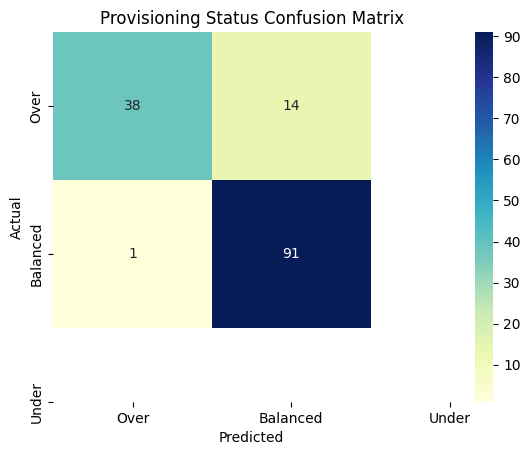

In [5]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu", xticklabels=["Over", "Balanced", "Under"], yticklabels=["Over", "Balanced", "Under"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Provisioning Status Confusion Matrix")
plt.show()


## 🧮 Regression Model to Predict Target Utilization (TG)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predict TG as regression target
X_reg = df[["ConsumedRCU", "Hour", "DayOfWeek", "IsWeekend", "GrowthRate", "RollingMeanRCU"]]
y_reg = df["TargetUtilization(TG)"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(Xr_train, yr_train)

yr_pred = rf_reg.predict(Xr_test)
print("RMSE for TG prediction:", sqrt(mean_squared_error(yr_test, yr_pred)))


RMSE for TG prediction: 0.11165021645000664


## 🔢 Regression Model to Predict Optimal ProvisionedRCU

In [9]:
# Predict optimal provisioned RCU directly
y_prov = df["ProvisionedRCU"]
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_reg, y_prov, test_size=0.2, random_state=42)

rf_prov = RandomForestRegressor(n_estimators=100, random_state=42)
rf_prov.fit(Xp_train, yp_train)

yp_pred = rf_prov.predict(Xp_test)
print("RMSE for ProvisionedRCU prediction:", sqrt(mean_squared_error(yp_test, yp_pred)))


RMSE for ProvisionedRCU prediction: 666.9583280075383


## 🔮 Forecasting ConsumedRCU using Facebook Prophet

/opt/anaconda3/envs/nn_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
09:09:09 - cmdstanpy - INFO - Chain [1] start processing
09:09:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/nn_env/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


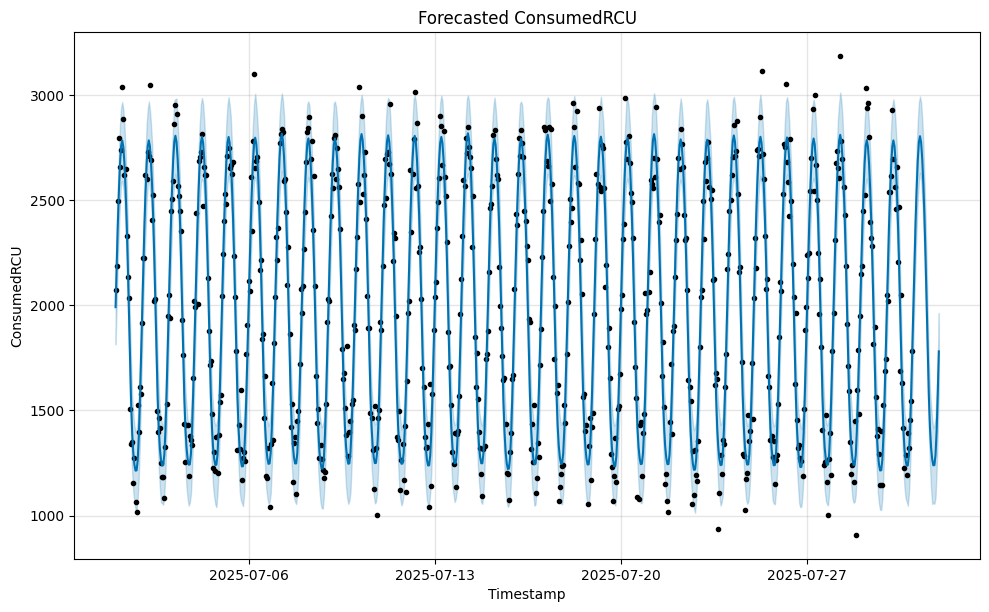

,ds,yhat,yhat_lower,yhat_upper
734,2025-07-31 14:00:00,1569.255672,1384.874187,1732.279151
735,2025-07-31 15:00:00,1419.054394,1238.545768,1596.647006
736,2025-07-31 16:00:00,1323.702269,1122.713585,1521.942000
737,2025-07-31 17:00:00,1268.304880,1055.642032,1453.619657
738,2025-07-31 18:00:00,1239.456046,1062.366134,1418.407204
739,2025-07-31 19:00:00,1240.349329,1056.386652,1426.931296
740,2025-07-31 20:00:00,1288.846624,1086.710265,1467.283794
741,2025-07-31 21:00:00,1400.521114,1212.547489,1604.107390
742,2025-07-31 22:00:00,1572.301034,1387.363184,1740.206422
743,2025-07-31 23:00:00,1781.151786,1599.470981,1964.032221


In [10]:
from prophet import Prophet

# Prepare data
df_prophet = df[["Timestamp", "ConsumedRCU"]].rename(columns={"Timestamp": "ds", "ConsumedRCU": "y"})

# Train model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Forecast next 24 hours
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Forecasted ConsumedRCU")
plt.xlabel("Timestamp")
plt.ylabel("ConsumedRCU")
plt.show()

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10)


## 🧠 Calculate Recommended ProvisionedRCU Based on Forecasted yhat and yhat_upper

In [11]:
# Add recommendations to forecast DataFrame
# Choose a fixed Target Utilization (TG) for provisioning
chosen_tg = 0.70

# Only calculate for newly forecasted periods
forecast_future = forecast[forecast['ds'] > df['Timestamp'].max()].copy()

# Add recommended provisioning
forecast_future['RecommendedProvisionedRCU'] = forecast_future['yhat'] / chosen_tg
forecast_future['ProvisionedRCU_UpperSafe'] = forecast_future['yhat_upper'] / chosen_tg

# Display results
forecast_future[['ds', 'yhat', 'RecommendedProvisionedRCU', 'ProvisionedRCU_UpperSafe']].tail(10)


,ds,yhat,RecommendedProvisionedRCU,ProvisionedRCU_UpperSafe
734,2025-07-31 14:00:00,1569.255672,2241.793817,2474.684501
735,2025-07-31 15:00:00,1419.054394,2027.220563,2280.924294
736,2025-07-31 16:00:00,1323.702269,1891.003241,2174.202858
737,2025-07-31 17:00:00,1268.304880,1811.864115,2076.599510
738,2025-07-31 18:00:00,1239.456046,1770.651494,2026.296006
739,2025-07-31 19:00:00,1240.349329,1771.927613,2038.473280
740,2025-07-31 20:00:00,1288.846624,1841.209463,2096.119706
741,2025-07-31 21:00:00,1400.521114,2000.744448,2291.581986
742,2025-07-31 22:00:00,1572.301034,2246.144335,2486.009175
743,2025-07-31 23:00:00,1781.151786,2544.502552,2805.760315


## 🎯 Recommend TG Dynamically Based on Predicted Usage Level

In [12]:
# Recommend TG based on predicted consumption level (yhat)
# Logic: low usage → higher TG (more aggressive), high usage → lower TG (more cautious)
def recommend_tg(usage):
    if usage < 1500:
        return 0.8  # high utilization to save cost
    elif usage < 2500:
        return 0.7
    elif usage < 3500:
        return 0.6
    else:
        return 0.5  # conservative TG for high load

forecast_future['RecommendedTG'] = forecast_future['yhat'].apply(recommend_tg)
forecast_future['RecommendedProvisionedRCU'] = forecast_future['yhat'] / forecast_future['RecommendedTG']
forecast_future['ProvisionedRCU_UpperSafe'] = forecast_future['yhat_upper'] / forecast_future['RecommendedTG']

# Display results
forecast_future[['ds', 'yhat', 'RecommendedTG', 'RecommendedProvisionedRCU', 'ProvisionedRCU_UpperSafe']].tail(10)


,ds,yhat,RecommendedTG,RecommendedProvisionedRCU,ProvisionedRCU_UpperSafe
734,2025-07-31 14:00:00,1569.255672,0.7,2241.793817,2474.684501
735,2025-07-31 15:00:00,1419.054394,0.8,1773.817993,1995.808757
736,2025-07-31 16:00:00,1323.702269,0.8,1654.627836,1902.427501
737,2025-07-31 17:00:00,1268.304880,0.8,1585.381101,1817.024571
738,2025-07-31 18:00:00,1239.456046,0.8,1549.320057,1773.009005
739,2025-07-31 19:00:00,1240.349329,0.8,1550.436662,1783.664120
740,2025-07-31 20:00:00,1288.846624,0.8,1611.058280,1834.104742
741,2025-07-31 21:00:00,1400.521114,0.8,1750.651392,2005.134238
742,2025-07-31 22:00:00,1572.301034,0.7,2246.144335,2486.009175
743,2025-07-31 23:00:00,1781.151786,0.7,2544.502552,2805.760315


## 📋 Evaluate Provisioning Status for Recommendations

In [13]:
# Calculate actual utilization for the recommendation
forecast_future['PredictedUtilization'] = forecast_future['yhat'] / forecast_future['RecommendedProvisionedRCU']

# Label provisioning status based on utilization
def classify_provisioning_status(util):
    if util > 0.9:
        return "Under-Provisioned"
    elif util < 0.6:
        return "Over-Provisioned"
    else:
        return "Balanced"

forecast_future['RecommendedProvisioningStatus'] = forecast_future['PredictedUtilization'].apply(classify_provisioning_status)

# Show final result
forecast_future[['ds', 'yhat', 'RecommendedTG', 'RecommendedProvisionedRCU', 'PredictedUtilization', 'RecommendedProvisioningStatus']].tail(10)


,ds,yhat,RecommendedTG,RecommendedProvisionedRCU,PredictedUtilization,RecommendedProvisioningStatus
734,2025-07-31 14:00:00,1569.255672,0.7,2241.793817,0.7,Balanced
735,2025-07-31 15:00:00,1419.054394,0.8,1773.817993,0.8,Balanced
736,2025-07-31 16:00:00,1323.702269,0.8,1654.627836,0.8,Balanced
737,2025-07-31 17:00:00,1268.304880,0.8,1585.381101,0.8,Balanced
738,2025-07-31 18:00:00,1239.456046,0.8,1549.320057,0.8,Balanced
739,2025-07-31 19:00:00,1240.349329,0.8,1550.436662,0.8,Balanced
740,2025-07-31 20:00:00,1288.846624,0.8,1611.058280,0.8,Balanced
741,2025-07-31 21:00:00,1400.521114,0.8,1750.651392,0.8,Balanced
742,2025-07-31 22:00:00,1572.301034,0.7,2246.144335,0.7,Balanced
743,2025-07-31 23:00:00,1781.151786,0.7,2544.502552,0.7,Balanced
